## 1. Libraries and data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import pickle

In [2]:
# Load data
data = pd.read_csv("training_data/sales.csv")

## 2. ETL

In [3]:
# Explore the data
display(data.sample(10))
display(data.info())
print("Max sale:", data["sales"].max())

Unnamed: 0  store_ID  day_of_week        date  nb_customers_on_day  \
472545      563612       512            2  2014-02-04                 1407   
362537      227489       618            6  2013-07-06                  501   
268349      491113        67            6  2015-01-17                  573   
467052      132065       139            4  2014-06-12                  463   
241981      566410       663            7  2013-02-03                    0   
599046      275167       665            2  2014-09-02                 1305   
39470       384357       597            1  2015-01-12                  764   
303928      458912        85            3  2013-01-16                  808   
357161      427526       781            1  2014-09-22                  571   
512714      357143       634            1  2014-08-04                 1027   

        open  promotion state_holiday  school_holiday  sales  
472545     1          1             0               0   6004  
362537     1          0             0               1   6328  
268349     1          0             0               0   5461  
467052     1          0             0               1   5638  
241981     0          0             0               0      0  
599046     1          1             0               1   9588  
39470      1          1             0               0   5827  
303928     1          0             0               0   5025  
357161     1          0             0               0   3613  
512714     1          1             0               1  11904

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           640840 non-null  int64 
 1   store_ID             640840 non-null  int64 
 2   day_of_week          640840 non-null  int64 
 3   date                 640840 non-null  object
 4   nb_customers_on_day  640840 non-null  int64 
 5   open                 640840 non-null  int64 
 6   promotion            640840 non-null  int64 
 7   state_holiday        640840 non-null  object
 8   school_holiday       640840 non-null  int64 
 9   sales                640840 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 48.9+ MB


None

Max sale: 41551


In [4]:
# It's weird that state_holiday, let's see why
display(data["state_holiday"].unique())

array(['0', 'a', 'c', 'b'], dtype=object)

In [5]:
def data_etl(df):
    # There are three different state holidays, so we'll one-hot-encode them
    df = pd.get_dummies(df, columns=["state_holiday"], prefix="state_holiday", drop_first=True)

    # We'll one-hot-encode day_of_week too so every day is equally important
    df = pd.get_dummies(df, columns=["day_of_week"], prefix="day_of_week", drop_first=False)

    # We'll turn date into an integer too
    df['date'] = df['date'].str.replace('-', '').astype('int64')

    df = df.replace({True:1,False:0})

    # We don't need "Unnamed: 0"
    df = df.drop("Unnamed: 0", axis=1)
    
    return df

In [6]:
data = data_etl(data)

C:\Users\Saul\AppData\Local\Temp\ipykernel_16360\4084594816.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True:1,False:0})


In [7]:
display(data.sample(10))
display(data.info())

store_ID      date  nb_customers_on_day  open  promotion  \
533466       438  20140226                  414     1          0   
309260       328  20150722                  496     1          0   
134178       631  20150303                  716     1          1   
388442        14  20140728                  732     1          1   
388722      1013  20150618                  435     1          1   
218764       523  20130312                 1991     1          0   
98030       1031  20130920                  334     1          0   
370189       729  20130501                    0     0          1   
52948        363  20140215                  889     1          0   
276553       126  20140225                  492     1          0   

        school_holiday  sales  state_holiday_a  state_holiday_b  \
533466               1   3400                0                0   
309260               1   4001                0                0   
134178               0   6598                0                0   
388442               1   6906                0                0   
388722               0   4143                0                0   
218764               0  17117                0                0   
98030                0   3389                0                0   
370189               0      0                1                0   
52948                0   6717                0                0   
276553               0   4897                0                0   

        state_holiday_c  day_of_week_1  day_of_week_2  day_of_week_3  \
533466                0              0              0              1   
309260                0              0              0              1   
134178                0              0              1              0   
388442                0              1              0              0   
388722                0              0              0              0   
218764                0              0              1              0   
98030                 0              0              0              0   
370189                0              0              0              1   
52948                 0              0              0              0   
276553                0              0              1              0   

        day_of_week_4  day_of_week_5  day_of_week_6  day_of_week_7  
533466              0              0              0              0  
309260              0              0              0              0  
134178              0              0              0              0  
388442              0              0              0              0  
388722              1              0              0              0  
218764              0              0              0              0  
98030               0              1              0              0  
370189              0              0              0              0  
52948               0              0              1              0  
276553              0              0              0              0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   store_ID             640840 non-null  int64
 1   date                 640840 non-null  int64
 2   nb_customers_on_day  640840 non-null  int64
 3   open                 640840 non-null  int64
 4   promotion            640840 non-null  int64
 5   school_holiday       640840 non-null  int64
 6   sales                640840 non-null  int64
 7   state_holiday_a      640840 non-null  int64
 8   state_holiday_b      640840 non-null  int64
 9   state_holiday_c      640840 non-null  int64
 10  day_of_week_1        640840 non-null  int64
 11  day_of_week_2        640840 non-null  int64
 12  day_of_week_3        640840 non-null  int64
 13  day_of_week_4        640840 non-null  int64
 14  day_of_week_5        640840 non-null  int64
 15  day_of_week_6        640840 non-null  int64
 16  da

None

## 3. Correlation Matrix

Unnamed: 0  store_ID      date  nb_customers_on_day  \
Unnamed: 0             1.000000 -0.001098 -0.000203            -0.000932   
store_ID              -0.001098  1.000000 -0.000137             0.023605   
date                  -0.000203 -0.000137  1.000000            -0.000936   
nb_customers_on_day   -0.000932  0.023605 -0.000936             1.000000   
open                   0.000083 -0.001108 -0.001118             0.617264   
promotion             -0.001569 -0.000364  0.024148             0.315858   
school_holiday        -0.000319 -0.000706 -0.032965             0.071085   
state_holiday_a        0.000607  0.001005  0.010634            -0.182142   
state_holiday_b        0.000127  0.000016  0.013868            -0.103493   
state_holiday_c       -0.000829 -0.000866 -0.026057            -0.083525   
day_of_week_1          0.000226  0.000565 -0.001592             0.157166   
day_of_week_2          0.001511 -0.000310 -0.005026             0.112621   
day_of_week_3         -0.000019 -0.000217  0.000411             0.077257   
day_of_week_4         -0.001816 -0.000452  0.004461             0.057364   
day_of_week_5          0.000827 -0.000622  0.003384             0.096531   
day_of_week_6         -0.000296 -0.000231 -0.001125             0.020972   
day_of_week_7         -0.000433  0.001274 -0.000534            -0.523083   

                         open  promotion  school_holiday  state_holiday_a  \
Unnamed: 0           0.000083  -0.001569       -0.000319         0.000607   
store_ID            -0.001108  -0.000364       -0.000706         0.001005   
date                -0.001118   0.024148       -0.032965         0.010634   
nb_customers_on_day  0.617264   0.315858        0.071085        -0.182142   
open                 1.000000   0.294936        0.085213        -0.303459   
promotion            0.294936   1.000000        0.066565        -0.004241   
school_holiday       0.085213   0.066565        1.000000         0.030275   
state_holiday_a     -0.303459  -0.004241        0.030275         1.000000   
state_holiday_b     -0.174644   0.019809        0.158722        -0.011634   
state_holiday_c     -0.138651  -0.050382        0.137570        -0.009169   
day_of_week_1        0.130182   0.130844        0.061574         0.015762   
day_of_week_2        0.171875   0.126291        0.076997        -0.029268   
day_of_week_3        0.156625   0.126617        0.063323        -0.010675   
day_of_week_4        0.101176   0.127710        0.063588         0.128185   
day_of_week_5        0.131319   0.127346        0.073417        -0.002329   
day_of_week_6        0.179124  -0.320364       -0.169918        -0.049960   
day_of_week_7       -0.872404  -0.319808       -0.169738        -0.052048   

                     state_holiday_b  state_holiday_c  day_of_week_1  \
Unnamed: 0                  0.000127        -0.000829       0.000226   
store_ID                    0.000016        -0.000866       0.000565   
date                        0.013868        -0.026057      -0.001592   
nb_customers_on_day        -0.103493        -0.083525       0.157166   
open                       -0.174644        -0.138651       0.130182   
promotion                   0.019809        -0.050382       0.130844   
school_holiday              0.158722         0.137570       0.061574   
state_holiday_a            -0.011634        -0.009169       0.015762   
state_holiday_b             1.000000        -0.005217       0.083466   
state_holiday_c            -0.005217         1.000000      -0.026081   
day_of_week_1               0.083466        -0.026081       1.000000   
day_of_week_2              -0.033244        -0.026200      -0.166198   
day_of_week_3              -0.033236         0.024550      -0.166161   
day_of_week_4              -0.033304         0.063454      -0.166501   
day_of_week_5               0.082602         0.016209      -0.166676   
day_of_week_6              -0.033172        -0.026144      -0.165839   
day_of_week_7              -0.033114     

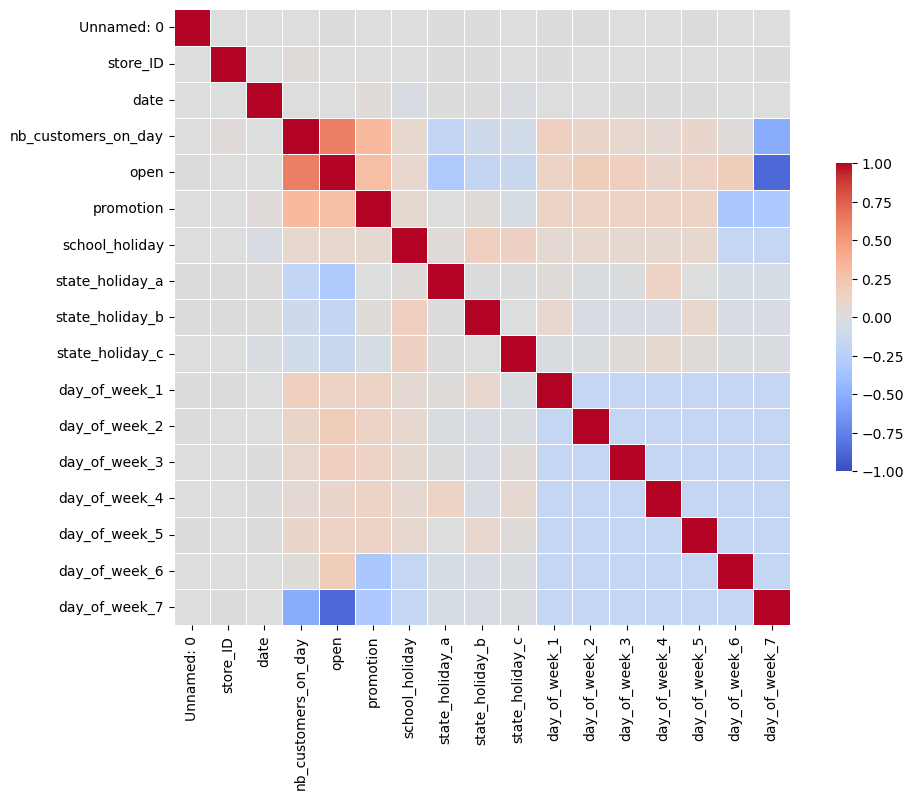

In [8]:
# Check correlation between features
corr = data.drop("sales",axis=1).corr()
display(corr)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, vmax=1, vmin=-1, square=True, linewidths=.5, cmap="coolwarm", cbar_kws={"shrink": .5}) # Most of these arguments are not really useful in this case
plt.show()

# It seems that there is a somewhat high correlation between Sundays (day_of_week_7) and closed stores (open=0), but not strong enough to drop any of these features

## 4. Feature Scaling (Standardization)

In [8]:
scaler = StandardScaler()

X = data.drop("sales",axis=1)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

y = data["sales"]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

## 5. Model Cross Validation

In [10]:
# Define the models and the sample size
models = {
    "Linear Regression": LinearRegression(),
    # "Decision Tree_4": DecisionTreeRegressor(max_depth=4),
    # "Decision Tree_5": DecisionTreeRegressor(max_depth=5),
    # "Random Forest_50": RandomForestRegressor(n_estimators=50),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    # "Random Forest_200": RandomForestRegressor(n_estimators=200),
    # "KNN_3": KNeighborsRegressor(n_neighbors=3),
    # "KNN_5": KNeighborsRegressor(n_neighbors=5),
    # "KNN_7": KNeighborsRegressor(n_neighbors=7),
    # "SVR_rbf": SVR(kernel="rbf"),
    # "SVR_linear": SVR(kernel="linear"),
    "GBR": GradientBoostingRegressor(n_estimators=2000, learning_rate=0.3)
}

sample_size = 3000

In [12]:
# Check the R2-score of each model and choose the best-performing ones
for name, model in models.items():
    scores = cross_val_score(model, X_train.head(sample_size), y_train.head(sample_size), scoring="r2")
    print(f"{name}: R2-score:\t{np.mean(scores):.5f}")

Linear Regression: R2-score:	0.85521
Random Forest: R2-score:	0.85378
GBR: R2-score:	0.86774


## 6. Hyperparameter Tuning

In [16]:
# Linear Regression
models["Linear Regression"].fit(X_train.head(sample_size),y_train.head(sample_size))
y_pred_LN = models["Linear Regression"].predict(X_train.tail(sample_size))
r2_LN = r2_score(y_train.tail(sample_size), y_pred_LN)
print(f"R2-score for Linear Regression ({sample_size} samples): {r2_LN:.5f}")

R2-score for Linear Regression (3000 samples): 0.85623


In [17]:
# Random Forest 
# tuned_RF = RandomizedSearchCV(estimator=models["Random Forest"], param_distributions={'n_estimators': [50, 100, 150, 200], 'max_depth': [10, 20, 30, None]}, cv=5, scoring='r2')
tuned_RF = RandomForestRegressor(n_estimators=100, max_depth=20)
tuned_RF.fit(X_train.head(sample_size),y_train.head(sample_size))
y_pred_RF = tuned_RF.predict(X_train.tail(sample_size))
r2_RF = r2_score(y_train.tail(sample_size), y_pred_RF)
print(f"R2-score for Random Forest ({sample_size} samples): {r2_RF:.5f}")

R2-score for Random Forest (3000 samples): 0.86647


In [12]:
# Gradient Boosting
# tuned_GB = RandomizedSearchCV(estimator=models["GBR"], param_distributions={'n_estimators': [250, 500, 1000, 2000], 'learning_rate': [0.1, 0.2, 0.3]}, cv=5, scoring='r2', verbose=3)

tuned_GB = GradientBoostingRegressor(n_estimators=250, learning_rate=0.3)
tuned_GB.fit(X_train.head(sample_size),y_train.head(sample_size))
y_pred_GB = tuned_GB.predict(X_train.tail(sample_size))
r2_GB = r2_score(y_train.tail(sample_size), y_pred_GB)
print(f"R2-score for Gradient Boosting ({sample_size} samples): {r2_GB:.5f}")

R2-score for Gradient Boosting (3000 samples): 0.88108


In [19]:
## We tried stacking three different models, but it was too computationally demanding
# base_models = [
#         ("ln", models["Linear Regression"]),
#         ("rf", tuned_RF),
#         ("gb", tuned_GB)
# ]

# meta_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# trained_model = meta_model.fit(X_train,y_train)
# y_pred_LN = trained_model.predict(X_test)
# r2_LN = r2_score(y_test, y_pred_LN)
# print(f"R2-score for Linear Regression: {r2_LN:.5f}")

## 7. Model Predictions

In [14]:
# We now test the best-scoring model with the whole dataset
trained_model = tuned_GB.fit(X_train,y_train)
y_pred = trained_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2-score: {r2:.5f}")

R2-score: 0.93875


## 8. Saving

In [16]:
pickle.dump(trained_model, open("trained_model.pkl", "wb"))